## Task 1 (Supervised Learning) - Predicting Donation and Donation Type

In this task you should target 3 classification tasks:
1. **Predicting  Donation (binary classification task)**; 
2. **Predicting Donation TYPE (multiclass classification)**; and
3. **Train specialized models for SES (socioeconomic classification)**.

**You should:**

* Choose **one classifier in each category**: Tree models, Rule models, Linear models, Distance-based models, and Probabilistic models.
* Use cross-validation to evaluate the results. 
* Present and discuss the results for different evaluation measures, present confusion matrices. Remember that not only overall results are important. Check what happens when learning to predict each class.
* Describe the parameters used for each classifier and how their choice impacted or not the results.
* Choose the best classifier and fundament you choice.
* **Discuss critically your choices and the results!**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from subprocess import call
import pydot
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from multi_imbalance.utils.plot import plot_cardinality_and_2d_data

### Preprocessing Data for Classification

In [2]:
df_clean = pd.read_csv('donors_dataset_clean.csv') 
df_clean.head()

,TARGET_B,TARGET_D,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,SES,CLUSTER_CODE,INCOME_GROUP,MOR_HIT_RATE,MEDIAN_HOME_VALUE,...,LIFETIME_GIFT_RANGE_BIN,LAST_GIFT_AMT_BIN,CARD_PROM_12_BIN,NUMBER_PROM_12_BIN,MONTHS_SINCE_LAST_GIFT_BIN,MONTHS_SINCE_FIRST_GIFT_BIN,FILE_CARD_GIFT_BIN,INCOME_GROUP_BIN,RECENCY_STATUS_96NK_e,DONATION_TYPE
0,1.0,10.0,137.0,79.000000,0.0,2.0,45.0,7.0,0.0,334.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(20.0, 30.0]","(-0.1, 8.0]","(120.0, 260.0]","(10.0, 20.0]","(6.4, 8.337]",4.0,D
1,0.0,0.0,113.0,75.000000,0.0,1.0,11.0,5.0,0.0,2388.0,...,"(15.0, 30.0]","(15.0, 30.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(4.4, 5.4]",4.0,NaN
2,0.0,0.0,92.0,62.695162,0.0,2.0,4.0,6.0,0.0,1688.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(5.4, 6.4]",0.0,NaN
3,0.0,0.0,101.0,74.000000,0.0,2.0,49.0,2.0,8.0,514.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(1.4, 2.4]",0.0,NaN
4,0.0,0.0,101.0,63.000000,0.0,3.0,8.0,3.0,0.0,452.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(2.4, 3.4]",0.0,NaN


#### Data and classes: SES

In this task we will need the same subset as in Task 1.2. Thus, without considering the columns: TARGET_B, TARGET_D and binned data. In addition, we will need to create one subset for each SES class. 

In [3]:
categorical_columns = ['DONOR_AGE_BIN', 'MONTHS_SINCE_ORIGIN_BIN', 'INCOME_GROUP_BIN', 'MOR_HIT_RATE_BIN', 'MEDIAN_HOME_VALUE_BIN', 
                       'MEDIAN_HOUSEHOLD_INCOME_BIN', 'PCT_OWNER_OCCUPIED_BIN', 'PER_CAPITA_INCOME_BIN', 'PCT_ATTRIBUTE1_BIN',
                      'PCT_ATTRIBUTE2_BIN', 'PCT_ATTRIBUTE3_BIN', 'PCT_ATTRIBUTE4_BIN', 'RECENT_RESPONSE_PROP_BIN',
                      'RECENT_AVG_GIFT_AMT_BIN', 'RECENT_CARD_RESPONSE_PROP_BIN', 'RECENT_AVG_CARD_GIFT_AMT_BIN',
                      'RECENT_RESPONSE_COUNT_BIN', 'RECENT_CARD_RESPONSE_COUNT_BIN', 'MONTHS_SINCE_LAST_PROM_RESP_BIN',
                      'LIFETIME_CARD_PROM_BIN', 'LIFETIME_PROM_BIN', 'LIFETIME_GIFT_AMOUNT_BIN','LIFETIME_GIFT_COUNT_BIN',
                      'LIFETIME_AVG_GIFT_AMT_BIN', 'LIFETIME_GIFT_RANGE_BIN', 'LAST_GIFT_AMT_BIN', 'CARD_PROM_12_BIN',
                      'NUMBER_PROM_12_BIN', 'MONTHS_SINCE_LAST_GIFT_BIN', 'MONTHS_SINCE_FIRST_GIFT_BIN', 'FILE_CARD_GIFT_BIN']

In [4]:
# Subset
df_clean.drop(df_clean[df_clean['DONATION_TYPE'].isnull()].index, inplace=True)
df_clean.drop(columns = categorical_columns, inplace=True)
df_clean.drop(columns=['TARGET_B','TARGET_D'], inplace=True)

In [5]:
# SES Classes
df_clean['SES'].unique()

array([2., 3., 1., 4.])

In [6]:
# Encode the categorical data
ord_enc = OrdinalEncoder()
df_clean["DONATION_TYPE"] = ord_enc.fit_transform(df_clean[["DONATION_TYPE"]])

In [7]:
# Create one subset for each SES class
ses1 = df_clean.loc[df_clean['SES'] == 1]
ses2 = df_clean.loc[df_clean['SES'] == 2]
ses3 = df_clean.loc[df_clean['SES'] == 3]
ses4 = df_clean.loc[df_clean['SES'] == 4]

In [8]:
def ses_class(ses):
    '''Perform data transformation from DataFrame to array.'''
    nc = ses.shape[1] 
    matrix = ses.values 
    X = matrix [:, 0:nc-1] 
    y = matrix [:, nc-1]         
    features = ses.columns.values[0:nc-1]
    target = ses.columns.values[nc-1] 
    return nc, matrix, X, y, features, target

In [9]:
nc1, matrix1, X1, y1, features1, target1 = ses_class(ses1)
nc2, matrix2, X2, y2, features2, target2 = ses_class(ses2)
nc3, matrix3, X3, y3, features3, target3 = ses_class(ses3)
nc4, matrix4, X4, y4, features4, target4 = ses_class(ses4)

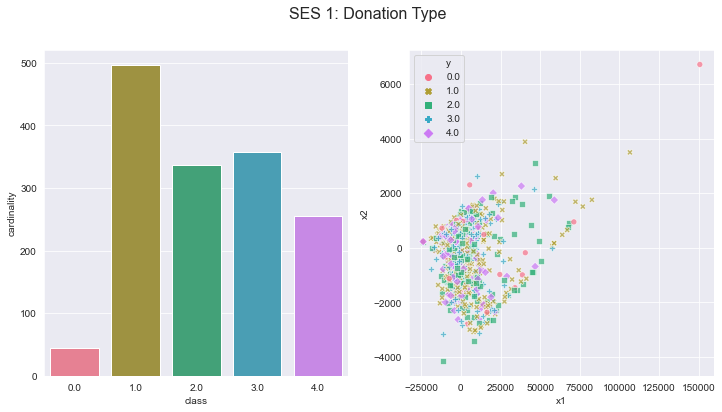

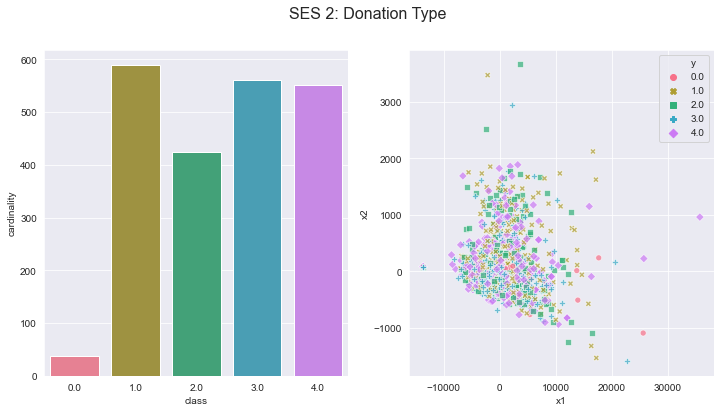

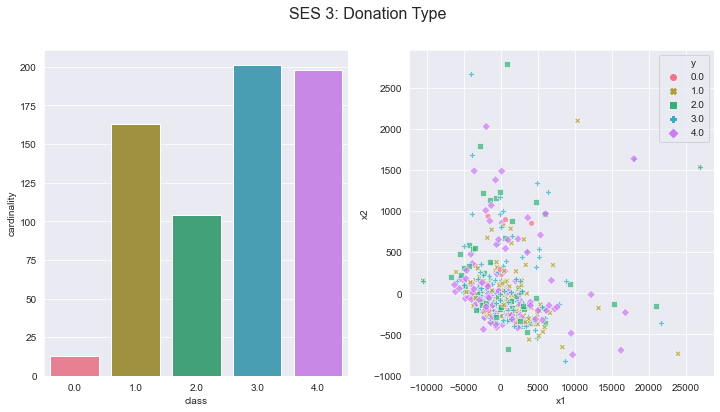

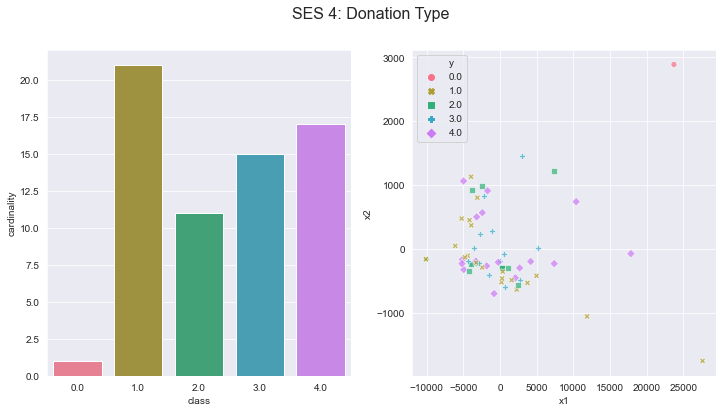

In [10]:
# Visualization of the classes for each SES class
# Plot 1 (left): Barplot with the cardinality of classes from y
# Plot2 (right): Scatter plot of X transformed to two dimensions using PCA
plot_cardinality_and_2d_data(X1, y1, 'SES 1: Donation Type')
plot_cardinality_and_2d_data(X2, y2, 'SES 2: Donation Type')
plot_cardinality_and_2d_data(X3, y3, 'SES 3: Donation Type')
plot_cardinality_and_2d_data(X4, y4, 'SES 4: Donation Type')

The data for the four classes is imbalanced for Class 0. This is to be expected as the original dataset also showed a high imbalance level in that class. Following the steps taken in the previous tasks, we will perform a data split with stratification and cross validation with a StratifiedKFold approach.

Donation Type A in SES Class 4 had to be removed since it had one single element, thus we would not have been able to split the data for that donation type. We will keep the four remaining donation types.

In [11]:
# Finding the index for the data point corresponding to class 0 and removing the element in that position in X and y
index = np.where(y4==0)
y4 = np.delete(y4,index)
X4 = np.delete(X4,index,0)

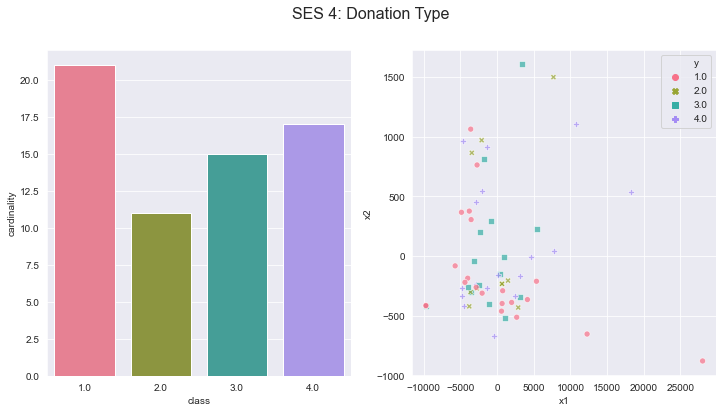

In [12]:
# Data visualization for SES Class 4 after removal of Class 0 (Donation Type A)
plot_cardinality_and_2d_data(X4, y4, 'SES 4: Donation Type')

#### Traning and Testing Sets 

In [13]:
# Split the data - Training set: 0.75; Testing set: 0.25;

# Class 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, stratify=y1)
# Class 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, stratify=y2)
# Class 3
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=42, stratify=y3)
# Class 4
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, random_state=42, stratify=y4)

### Multiclass Classification: Decision Tree

In [14]:
## Classifier - With the parameters set at Task 1.2
dt = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10)

#### Cross-Validation 

In [15]:
ses_X = [X1, X2, X3, X4]
ses_y = [y1, y2, y3, y4]
names = ['SES Class 1', 'SES Class 2','SES Class 3','SES Class 4']

for X, y, name in zip(ses_X, ses_y, names):
    
    f1_macro = cross_val_score(dt, X, y, cv=10, scoring='f1_macro')
    f1_weighted = cross_val_score(dt, X, y, cv=10, scoring = 'f1_weighted')
    recall_macro = cross_val_score(dt, X, y, cv=10, scoring='recall_macro')
    recall_weighted  = cross_val_score(dt, X, y, cv=10, scoring = 'recall_weighted')
    accuracy_cv = cross_val_score(dt, X, y, cv=10, scoring='accuracy')
    
    print('Cross-Validation {name} - F1 Micro: %0.2f (+/- %0.2f)'.format(name=name) % (f1_macro.mean(), f1_macro.std() * 2))
    print('Cross-Validation {name} - F1 Weighted: %0.2f (+/- %0.2f)'.format(name=name) % (f1_weighted.mean(), f1_weighted.std() * 2))
    print('Cross-Validation {name} - Recall Micro: %0.2f (+/- %0.2f)'.format(name=name) % (recall_macro.mean(), recall_macro.std() * 2))
    print('Cross-Validation {name} - Recall Weighted: %0.2f (+/- %0.2f)'.format(name=name) % (recall_weighted.mean(), recall_weighted.std() * 2))
    print('Cross-Validation {name} - Accuracy: %0.2f (+/- %0.2f)'.format(name=name) % (accuracy_cv.mean(), accuracy_cv.std() * 2),'\n')

Cross-Validation SES Class 1 - F1 Micro: 0.61 (+/- 0.12)
Cross-Validation SES Class 1 - F1 Weighted: 0.63 (+/- 0.07)
Cross-Validation SES Class 1 - Recall Micro: 0.62 (+/- 0.12)
Cross-Validation SES Class 1 - Recall Weighted: 0.63 (+/- 0.07)
Cross-Validation SES Class 1 - Accuracy: 0.63 (+/- 0.07) 

Cross-Validation SES Class 2 - F1 Micro: 0.55 (+/- 0.08)
Cross-Validation SES Class 2 - F1 Weighted: 0.64 (+/- 0.05)
Cross-Validation SES Class 2 - Recall Micro: 0.55 (+/- 0.07)
Cross-Validation SES Class 2 - Recall Weighted: 0.64 (+/- 0.06)
Cross-Validation SES Class 2 - Accuracy: 0.64 (+/- 0.06) 

Cross-Validation SES Class 3 - F1 Micro: 0.50 (+/- 0.17)
Cross-Validation SES Class 3 - F1 Weighted: 0.61 (+/- 0.07)
Cross-Validation SES Class 3 - Recall Micro: 0.52 (+/- 0.17)
Cross-Validation SES Class 3 - Recall Weighted: 0.62 (+/- 0.07)
Cross-Validation SES Class 3 - Accuracy: 0.62 (+/- 0.07) 

Cross-Validation SES Class 4 - F1 Micro: 0.53 (+/- 0.40)
Cross-Validation SES Class 4 - F1 Weight

#### Training vs. Testing 

Accuracy Score Training Set SES Class 1 - F1 Macro:  0.6600658700779338
Accuracy Score Training Set SES Class 1 - F1 Weighted:  0.6626120724212969
Accuracy Score Training Set SES Class 1 - Recall Macro:  0.6516431304973797
Accuracy Score Training Set SES Class 1 - Recall Weighted:  0.6606982990152194
Accuracy Score Training Set SES Class 1 - Accuracy:  0.6606982990152194 

Accuracy Score Training Set SES Class 2 - F1 Macro:  0.6185603804870795
Accuracy Score Training Set SES Class 2 - F1 Weighted:  0.6515525101548175
Accuracy Score Training Set SES Class 2 - Recall Macro:  0.6248054647391549
Accuracy Score Training Set SES Class 2 - Recall Weighted:  0.6491985203452528
Accuracy Score Training Set SES Class 2 - Accuracy:  0.6491985203452528 

Accuracy Score Training Set SES Class 3 - F1 Macro:  0.6651938188596084
Accuracy Score Training Set SES Class 3 - F1 Weighted:  0.6848170844082676
Accuracy Score Training Set SES Class 3 - Recall Macro:  0.6571220556216757
Accuracy Score Training S

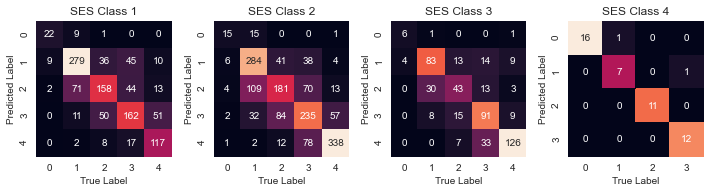

In [16]:
ses_X_train = [X_train1, X_train2, X_train3, X_train4]
ses_y_train = [y_train1, y_train2, y_train3, y_train4]
names = ['SES Class 1', 'SES Class 2','SES Class 3','SES Class 4']

f, axes = plt.subplots(1, 4, figsize=(10, 10))
f.tight_layout()

for X_train, y_train, name, i in zip(ses_X_train, ses_y_train, names, range(len(names))):
    
    dt = dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
        
    f1_macro = f1_score(y_train, y_pred, average='macro')
    f1_wighted = f1_score(y_train, y_pred, average='weighted')
    recall_macro = recall_score(y_train, y_pred, average='macro')
    recall_wighted = recall_score(y_train, y_pred, average='weighted')
    accuracy = accuracy_score(y_train, y_pred)
        
    print('Accuracy Score Training Set {name} - F1 Macro: '.format(name=name), f1_macro)
    print('Accuracy Score Training Set {name} - F1 Weighted: '.format(name=name), f1_wighted)
    print('Accuracy Score Training Set {name} - Recall Macro: '.format(name=name), recall_macro)
    print('Accuracy Score Training Set {name} - Recall Weighted: '.format(name=name), recall_wighted)
    print('Accuracy Score Training Set {name} - Accuracy: '.format(name=name), accuracy, '\n')
    
    cm_train = confusion_matrix(y_train, y_pred)
    
    sns.heatmap(cm_train.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title(name)

Accuracy Score Testing Set SES Class 1 - F1 Macro:  0.6007428031179447
Accuracy Score Testing Set SES Class 1 - F1 Weighted:  0.6011143800428685
Accuracy Score Testing Set SES Class 1 - Recall Macro:  0.5995970360284877
Accuracy Score Testing Set SES Class 1 - Recall Weighted:  0.5978552278820375
Accuracy Score Testing Set SES Class 1 - Accuracy:  0.5978552278820375 

Accuracy Score Testing Set SES Class 2 - F1 Macro:  0.6123353283430306
Accuracy Score Testing Set SES Class 2 - F1 Weighted:  0.6607876061906183
Accuracy Score Testing Set SES Class 2 - Recall Macro:  0.6269060733399183
Accuracy Score Testing Set SES Class 2 - Recall Weighted:  0.6580406654343808
Accuracy Score Testing Set SES Class 2 - Accuracy:  0.6580406654343808 

Accuracy Score Testing Set SES Class 3 - F1 Macro:  0.6081692859555713
Accuracy Score Testing Set SES Class 3 - F1 Weighted:  0.6826633132703593
Accuracy Score Testing Set SES Class 3 - Recall Macro:  0.6206554096310193
Accuracy Score Testing Set SES Class 3

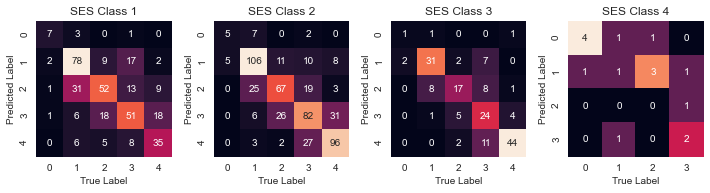

In [17]:
ses_X_train = [X_train1, X_train2, X_train3, X_train4]
ses_y_train = [y_train1, y_train2, y_train3, y_train4]
ses_X_test = [X_test1, X_test2, X_test3, X_test4]
ses_y_test = [y_test1, y_test2, y_test3, y_test4]
names = ['SES Class 1', 'SES Class 2','SES Class 3','SES Class 4']

f, axes = plt.subplots(1, 4, figsize=(10, 10))
f.tight_layout()

for X_test, y_test, X_train, y_train, name, i in zip(ses_X_test, ses_y_test, ses_X_train, ses_y_train, names, range(len(names))):
    
    dt = dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
        
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_wighted = f1_score(y_test, y_pred, average='weighted')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    recall_wighted = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
        
    print('Accuracy Score Testing Set {name} - F1 Macro: '.format(name=name), f1_macro)
    print('Accuracy Score Testing Set {name} - F1 Weighted: '.format(name=name), f1_wighted)
    print('Accuracy Score Testing Set {name} - Recall Macro: '.format(name=name), recall_macro)
    print('Accuracy Score Testing Set {name} - Recall Weighted: '.format(name=name), recall_wighted)
    print('Accuracy Score Testing Set {name} - Accuracy: '.format(name=name), accuracy, '\n')
        
    cm_test = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title(name)

### Results and Discussion  

The DT classifier seems to be performing above chance. These results are consistent with the ones achieved in Task 1.2. If we compare the distribution from SES Classes 1, 2 and 3 with their respective confusion matrixes, we can see a correlation between each class cardinality and the accuracy of its label prediction. Class 1 is larger than the other classes in SES Class 1, so it tends to exhibit better scores at its label prediction. On the contrary, donation Classes 3 and 4 for SES Class 3 have a higher prediction accuracy. In addition, similarly to Task 1.2, the model is not able to classify Class 0 for SES Class 1, 2 and 3. These results indicate that, although the classifier is less sensitive to class imbalance than the other models, it is still affected by it.
On the other hand, the most distinctive result for this task is for SES Class 4. Donation type A had to be removed, and the sample size for this dataset was extremely low. This might have lead to a higher level of heterogeneity between the splitted groups, which would explain the increased standard deviation values. Also, the small sample size could explain the overfitting of the training data, which is confirmed by the results for the training set. While the scores are still high, the great difference between the results of the training and testing sets shows a problem in the models ability to learn the task. 